In [20]:
import pandas as pd
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt

bids_folder = '/data/ds-risk'
sns.set_theme('paper', 'white', font='helvetica', font_scale=1.25, palette='tab10')
cm = 1/2.54  # centimeters in inches

In [21]:
ts = pd.read_csv(op.join(bids_folder, 'derivatives', 'pupil', 'model-n1_n2_n', 'timeseries.tsv'), sep='\t', index_col=[0,1,2,3])

In [22]:
import numpy as np

In [23]:
np.array([234,182,118]) / 255.

array([0.91764706, 0.71372549, 0.4627451 ])

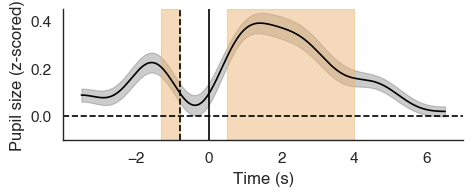

In [44]:
darkyellow = [0.91764706, 0.71372549, 0.4627451 ]
tmp = ts.xs('n1', 0, 'event type').xs('intercept', 0, 'covariate')

fac = sns.lineplot(tmp.reset_index(), x='time', y='pupil', errorbar='se', color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='-')
plt.axvline(-.8, c='k', ls='--')
plt.axhline(0.0, c='k', ls='--')

plt.ylim(-0.1, 0.45)
ylim = plt.ylim()
plt.fill_betweenx(ylim, -1.3, -.8, color=darkyellow, alpha=.5)
plt.fill_betweenx(ylim, .5, 4, color=darkyellow, alpha=.5)
plt.ylim(ylim)
plt.ylabel('Pupil size (z-scored)')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.gcf().set_size_inches(12*cm, 4*cm)

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1.pdf'), bbox_inches='tight')

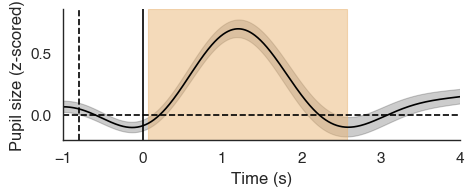

In [45]:
darkyellow = [0.91764706, 0.71372549, 0.4627451 ]
tmp = ts.xs('n2', 0, 'event type').xs('intercept', 0, 'covariate')

fac = sns.lineplot(tmp.reset_index(), x='time', y='pupil', errorbar='se', color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='-')
plt.axvline(-.8, c='k', ls='--')
plt.axhline(0.0, c='k', ls='--')

plt.ylim(-0.2, 0.85)
plt.xlim(-1., 4.)
ylim = plt.ylim()
plt.fill_betweenx(ylim, 0.07, 2.57, color=darkyellow, alpha=.5)
# plt.fill_betweenx(ylim, .5, 4, color=darkyellow, alpha=.5)
plt.ylim(ylim)
plt.ylabel('Pupil size (z-scored)')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.gcf().set_size_inches(12*cm, 4*cm)

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n2.pdf'), bbox_inches='tight')

Text(0.5, 1.0, 'N2')

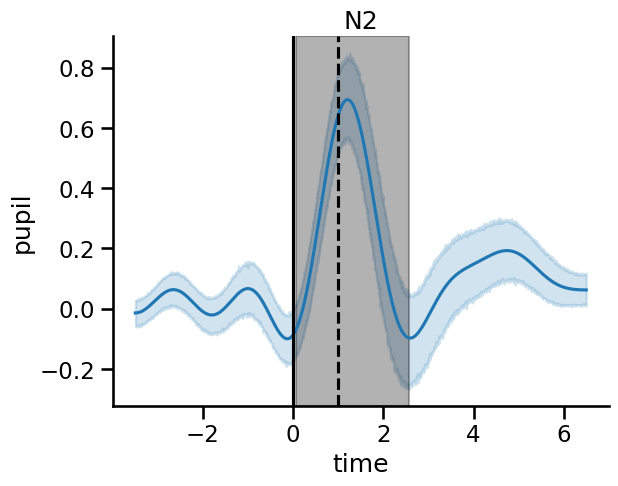

In [122]:
tmp = ts.xs('n2', 0, 'event type').xs('intercept', 0, 'covariate')

sns.lineplot(tmp.reset_index(), x='time', y='pupil')
sns.despine()

plt.axvline(0.0, c='k', ls='-')
plt.axvline(1.0, c='k', ls='--')

ylim = plt.ylim()
plt.fill_betweenx(ylim, 0.07, 2.57, color='k', alpha=.3)
# plt.fill_betweenx(ylim, .5, 4, color='k', alpha=.3)
plt.ylim(ylim)
plt.title('N2')

In [126]:
pupil = pd.read_csv(op.join(bids_folder, 'derivatives', 'pupil', 'model-n1_n2_n', 'pupil_pre_post12.tsv'), sep='\t', index_col=[0,1,2,3], dtype={'subject':str})

In [127]:
corrs = pupil.unstack(['event type', 'prepost']).pupil.groupby('subject').apply(lambda d: d.corr()).groupby(['event type', 'prepost']).mean()
corrs

event type                 n1                            n2
prepost                  post  post-pre       pre      post
event type prepost                                         
n1         post      1.000000  0.437576  0.421271  0.033809
           post-pre  0.437576  1.000000 -0.618687  0.128760
           pre       0.421271 -0.618687  1.000000 -0.096291
n2         post      0.033809  0.128760 -0.096291  1.000000

Text(34.08333333333332, 0.5, '')

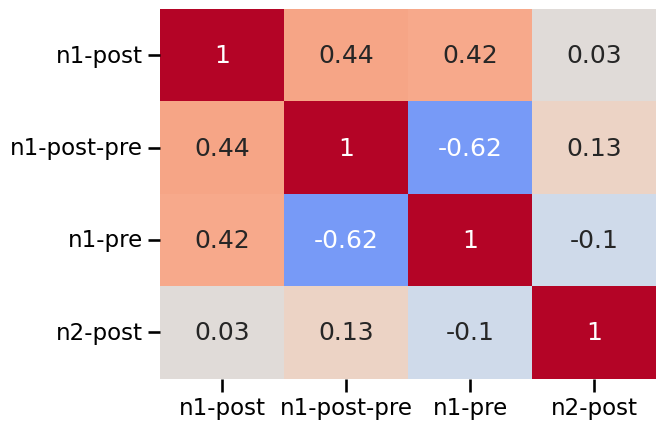

In [128]:
corrs = pupil.unstack(['event type', 'prepost']).pupil.groupby('subject').apply(lambda d: d.corr()).groupby(['event type', 'prepost']).mean()
sns.set_context('talk')
sns.heatmap(corrs.round(2), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
plt.xlabel(None)
plt.ylabel(None)

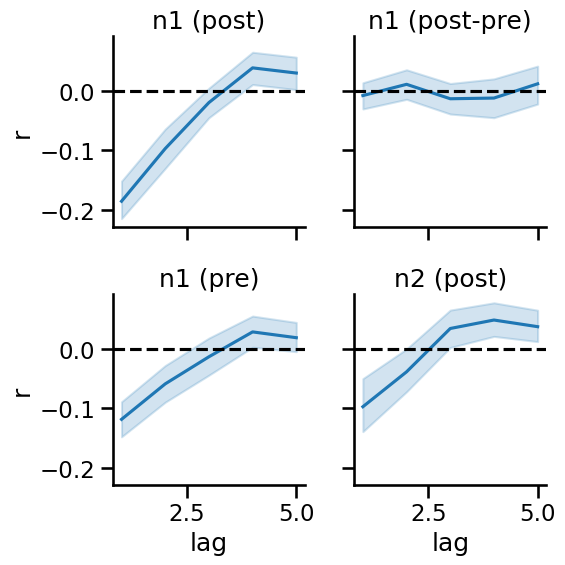

In [129]:

ars = []

lags = range(1, 6)

for lag in lags:
    ars.append(pupil.groupby(['subject', 'event type', 'prepost'])['pupil'].apply(lambda d: d.autocorr(lag=lag)))

ars = pd.concat(ars, keys=lags, names=['lag']).to_frame('r')

ars = ars.reset_index()

ars['event'] = ars.apply(lambda row: f'{row["event type"]} ({row.prepost})', axis=1)

fac = sns.FacetGrid(ars, col='event', col_wrap=2)
fac.map(sns.lineplot, 'lag', 'r', errorbar=('ci', 95))

fac.map(lambda *ars,**kwargs: plt.axhline(0.0, c='k', ls='--'))
fac.set_titles('{col_name}')

In [138]:
from risk_experiment.utils import get_all_subjects


decoding_info = pd.concat([sub.get_decoding_info('3t2', mask='npcr', n_voxels=0.0) for sub in get_all_subjects(bids_folder)])

In [139]:
decoding_info

E         sd
subject session mask n_voxels trial_nr                      
02      3t2     npcr 0.0      1         12.959348   8.327574
                              2          7.178416   2.850978
                              3         54.781945  20.166725
                              4         64.763165  38.890092
                              5         81.957788  21.428990
...                                           ...        ...
32      3t2     npcr 0.0      188       78.372064  22.144108
                              189       72.475513  18.030158
                              190       64.421085  29.522019
                              191       26.512952  11.253854
                              192       55.218235  37.524105

[5760 rows x 2 columns]

In [140]:
df = pupil.join(decoding_info)

In [141]:
df['event'] = df.reset_index().apply(lambda row: f'{row["event type"]} ({row.prepost})', 1).values

In [142]:
import pingouin

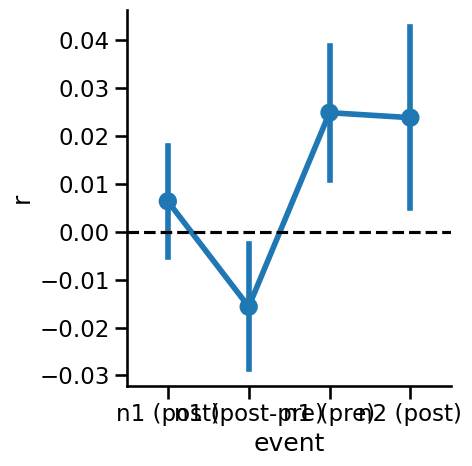

In [143]:
r = df.groupby(['subject', 'event type', 'prepost','event']).apply(lambda d: pingouin.corr(d['sd'], d['pupil']))

sns.catplot(r.reset_index(), x='event', y='r', kind='point', errorbar='se')
plt.axhline(0.0, c='k', ls='--')

In [144]:
import bambi as bmb

traces = []
keys = []

for event, d in df.groupby('event'):
    print(event)
    model = bmb.Model('sd ~ pupil + (pupil|subject)', data=d.reset_index())
    idata = model.fit(cores=1)
    traces.append(idata)
    keys.append(event)

n1 (post)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.


n1 (post-pre)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.


n1 (pre)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.


n2 (post)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.


In [145]:
traces = pd.concat([t.posterior['pupil'].to_dataframe() for t in traces], keys=keys, names=['event'])

In [146]:
decoding_info.index = decoding_info.index.set_levels(decoding_info.index.levels[0].astype(int), level='subject')

In [86]:
traces.groupby('event').apply(lambda d: (d['pupil'] > 0.0).mean())

event
n1 (post)        0.7155
n1 (post-pre)    0.0995
n1 (pre)         0.9605
n2 (post)        0.8790
dtype: float64

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/g

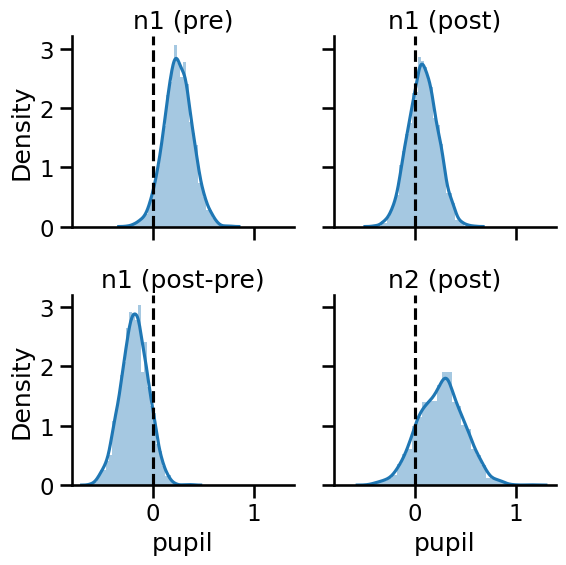

In [110]:
sns.set_context('talk')
fac = sns.FacetGrid(traces.reset_index(), col='event', col_wrap=2, col_order=['n1 (pre)', 'n1 (post)', 'n1 (post-pre)', 'n2 (post)'])
fac.map(sns.distplot, 'pupil')
fac.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))
fac.set_titles('{col_name}')

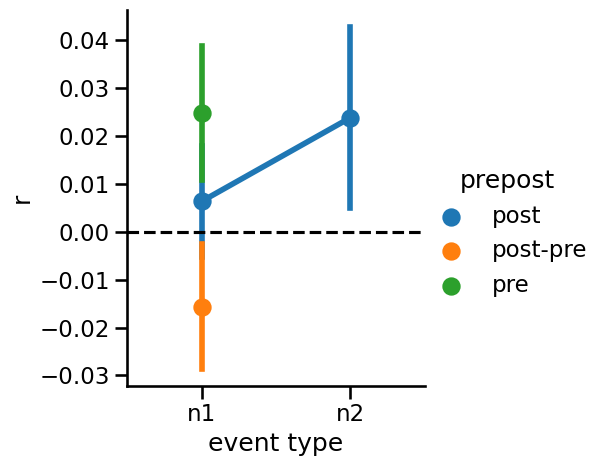

In [147]:
r = df.groupby(['subject', 'event type', 'prepost']).apply(lambda d: pingouin.corr(d['sd'], d['pupil']))

sns.catplot(r.reset_index(), x='event type', hue='prepost', y='r', kind='point', errorbar='se')
plt.axhline(0.0, c='k', ls='--')

In [149]:
df['q(pupil)'] = df.groupby(['subject', 'event type', 'prepost'], group_keys=False)['pupil'].apply(lambda x: pd.qcut(x, 5, labels=['q1', 'q2', 'q3', 'q4', 'q5']))

In [150]:
df['event'] = df.reset_index().apply(lambda row: f'{row["event type"]} ({row.prepost})', 1).values

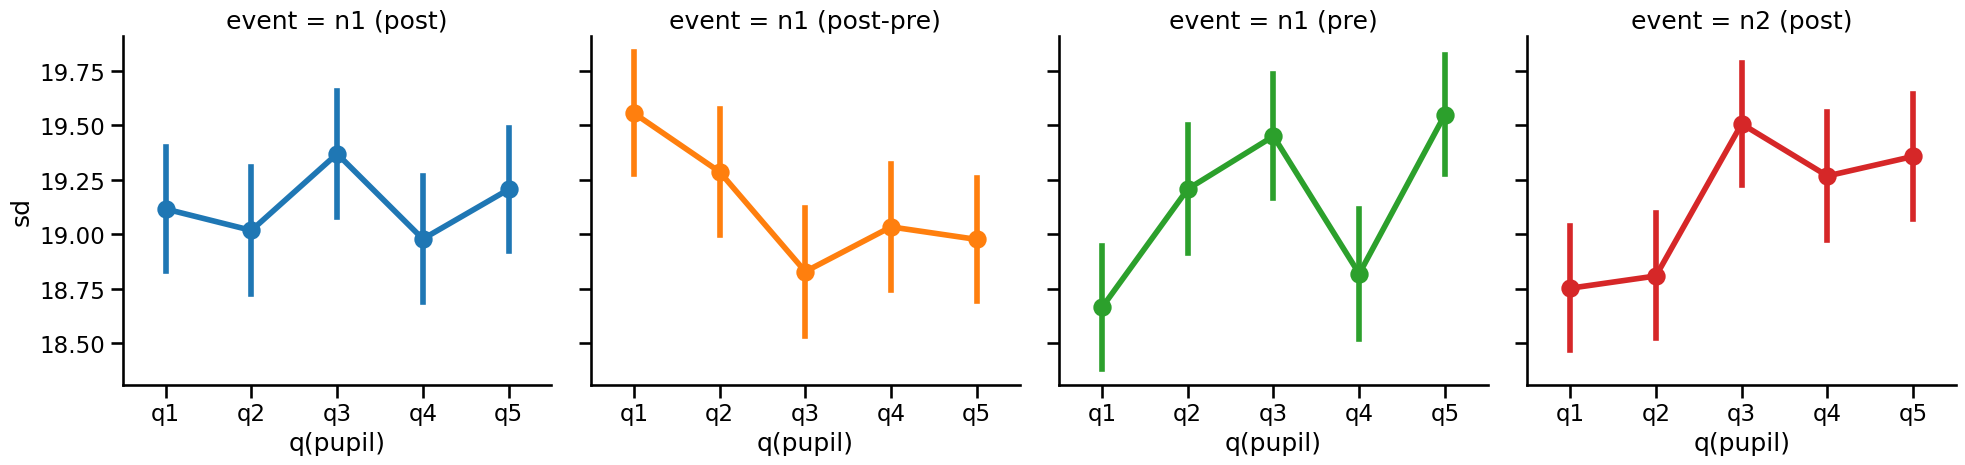

In [151]:
sns.catplot(data=df, x='q(pupil)', y='sd', hue='event', kind='point', col='event', errorbar='se')